# Holy Book Similarity Analysis

## CS410 Text Information Systems, Final Project, Fall 2018

Click here to start docker container at [mybinder](https://mybinder.org/v2/gh/jfmoran2/CS410_Public/master)

### Authors

Graham Chester - grahamc2: Division of Labour, 50% share: text processing, LDA, t-SNE coding, documentation, voiceover

John Moran - jfmoran2: Division of Labour, 50% share: sourcing, cleaning, preprocessing data, documentation, voiceover, mybinder setup, repo management.

## Functionality Overview

This Jupyter notebook tool was developed to enable the visualisation of similarities and differences of the major texts from many of the worlds largest religions. It also includes non-religious works from approximately similar periods (of translation) as a benchmark. While the tool is focused on religious works, it is general enough to be applied to be used to visualize the comparison of books from any genre.

The tool, as supplied, consists of a Jupyter notebook and the raw texts downloaded from the websites below. It requires the installation of a fairly standard Python data science stack as described in the installation section below.

### Data Sources

All books were sourced from open data sites in accordance with their licensing terms, as follows:

* Christianity: 2.2 billion followers, [King James Bible](http://www.o-bible.com/dlb.html)
* Islam: 1.6 billion followers, [Quran](http://tanzil.net/trans/) (Yusuf Ali version)
* Hinduism: 1 billion followers, [Bhagavad Gita](https://www.holybooks.com/bhagavad-gita-three-modern-translations/)
* Buddhism: 380 million followers, [Tipitaka](https://www.accesstoinsight.org/tech/download/bulk.html)
* Mormonism: 15 million followers, [Book of Mormon](http://holybooks.com/wp-content/uploads/2010/05/Book-of-Mormon.txt)
* Judaism: 14 million followers, [Torah](http://www.mechon-mamre.org/htmlzips/et002.zip)
* Shakespeare [collection](http://www.gutenberg.org/ebooks/author/65)
* Jane Austen [collecton](http://www.gutenberg.org/ebooks/search/?query=Jane+Austen)

## Installation

### Option 1: Cloud

There are two options for installation. The first and simplest isnt really installation at all. The Jupyter notebook can be started directly from [mybinder](https://mybinder.org/v2/gh/jfmoran2/CS410_Public/master). It will take several minutes to start as it copies across file from this github [repo](https://github.com/jfmoran2/CS410_Public), then builds and starts a docker container with the Python required libraries, but in the meantime you can browse the notebook itself.

### Option 2: Local Machine

This Jupyter notebook is built on a reasonably standard Python Data Science stack. Perhaps the easiest to install the prerequisites, if they are not already on your Windows, Mac or Linux machine, is to download and install Anaconda (Python version 3) from [here](https://www.anaconda.com/download), and then "conda install nltk", or refer to the official [NLTK website](http://www.nltk.org/install.html)

If you have an existing Python 3.5 or above installation and don't wish to install Anaconda, you can do the following, but you may need to be careful with versions:

```Python
pip install numpy scipy matplotlib pandas scikit-learn jupyter nltk
```

You will then need to clone or download the GitHub repo from [here](https://github.com/jfmoran2/CS410_Public). This contains the Jupyter notebook, and the raw religious texts in a directory called 'books-raw'.

At a terminal/command line window you then type 'jupyter notebook' in the dorectory that contains the notebook and books-raw directory. This will start the notebook server at port 8888 on your local machine and open a browser window. If you have any problems check this [quickstart guide](https://jupyter.readthedocs.io/en/latest/content-quickstart.html)

## Usage

Clicking on holybook.ipynb in the Jupyter notebook file browser window will open this notebook, and putting your cursor in a cell clicking on ">| Run" will run the cell. The processing steps in this notebook are:

1) **Load libraries**, initialize display options, download stopwords

2) **Define utility functions** for displaying similarity map, displaying topic words, and filtering text.

3) **Text Cleaning:** Sections to clean each book by reading the raw text from file(s) in the "books-raw" directory and creating a cleaned file in the 'books' directory. In the case of the old and new testament, a clean file is created for each chapter.

4) **Text Processing:** Stopword removal, stemming and lemmatization

5) **Word Count Vectorisation** using TFIDF

6) **Topic Discovery** using LDA

7) **t-SNE** based similarity mapping

8) **MDS** based similarity mapping


# Start of Processing

## Load libraries and initialise options and directory

In [3]:
import re
import glob
import lxml.html
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE, MDS

# set Jupyter to display ALL output from a cell (not just last output)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

# set pandas and numpy options to make print format nicer
pd.set_option("display.width",100)
pd.set_option("display.max_columns",1000)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
np.set_printoptions(linewidth=120, threshold=5000, edgeitems=10, suppress=True)

seed = 42

# create clean books directory if doesnt already exist
if not os.path.exists('books'): 
    os.makedirs('books')

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/graham/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Utility Functions

In [4]:
# plot similarity map and save as png file at good resolution
def plotmap(topics): 
    fig, ax = plt.subplots(figsize=(13,12))  # 12,11 or 8,7
    _ = ax.scatter(topics[:,0], topics[:,1], color='black', s=20)
    _ = plt.title('Holy Book Similarity Map', fontsize=20)
    # _ = plt.xlim(-40,60);  _ = plt.ylim(-65,60)
    _ = ax.grid()

    colourmap = {'OldTestmnt': 'dodgerblue', 'NewTestmnt': 'slateblue', 'Torah':'blue', 'Tipitaka':'palevioletred',
                  'Quran':'forestgreen', 'SiriGuruGranth':'teal', 'BhagavadGita':'indianred','BookofMormon': 'gold',
                  'Shakespeare':'darkviolet', 'JaneAusten':'magenta',}
    colours = [colourmap[book[:book.index("-")]] for book in book_names] 
    for i, txt in enumerate(book_names):
        _ = ax.annotate(txt, (topics[i,0], topics[i,1]), size=9, ha='center', rotation=0, color=colours[i])

    patchList = []
    for key in colourmap:
            data_key = mpatches.Patch(color=colourmap[key], label=key)
            patchList.append(data_key)
    _ = plt.legend(handles=patchList, fontsize=8)
    _ = plt.tight_layout()
    _ = plt.savefig('holybooksplot', dpi=200)
    _ = plt.show()
#     import mpld3
#     from mpld3 import plugins
#     # mpld3.display(fig)
#     mpld3.save_html(fig, 'index.html')

def display_topics(model, feature_names, num_top_words): # display words in topic
    for topic_idx, topic in enumerate(model.components_[:-1,:]):
        print("Topic%2d:" % (topic_idx), end='')
        print(",".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))
        
# common filtering function used by all books processes below
def stripper(instring):
    outstring = ' '.join(instring.split()).lower()
    outstring = ' '.join(re.findall("[a-zA-Z]+", outstring))
    return outstring

# calculate euclidean distance between two points
from math import hypot
def euclidean_distance(p1,p2):
    x1,y1 = p1
    x2,y2 = p2
    return round(hypot(x2 - x1, y2 - y1),4)

# create dataframe of distances between books
def calc_distances(topics):  
    distances = []
    book1 = []
    book2 = []
    for i, vector in enumerate(topics):
        for j in range(i+1,len(topics)):
            book1.append(book_names[i])
            book2.append(book_names[j])
            distances.append(euclidean_distance(topics[i], topics[j]))

    distances_df = pd.DataFrame({'book1': book1, 'book2': book2, 'distance':distances})
    distances_df = distances_df.sort_values('distance')
    return distances_df

### Process Old Testament

In [5]:
filename = 'OldTestmnt'
book = pd.read_csv('books-raw/'+filename+'-raw.txt', sep='~', header=None) # force all into one column
book['chapter'] = book[0].str.extract('([0-9]?[A-Za-z]*)', expand=False)
book['content'] = book[0].str.split(' ',1).str[1]
book.shape

for chapter in book.chapter.unique():
    content = book[book.chapter==chapter].content.to_string(index=False)
    content = stripper(content)
    with open('books/'+filename+'-'+chapter+'.txt', 'w') as text_file:
        _ = text_file.write(content)
    print(chapter, len(content),', ',end='')


(23145, 3)

Ge 190358 , Exo 164531 , Lev 123538 , Num 170811 , Deu 142384 , Josh 97230 , Jdgs 95839 , Ruth 12581 , 1Sm 125340 , 2Sm 103194 , 1Ki 123275 , 2Ki 117201 , 1Chr 107020 , 2Chr 135403 , Ezra 39153 , Neh 55193 , Est 29450 , Job 91361 , Psa 216651 , Prv 77744 , Eccl 27557 , SSol 13207 , Isa 188037 , Jer 217063 , Lam 17577 , Eze 199468 , Dan 60065 , Hos 26293 , Joel 10390 , Amos 21205 , Obad 3487 , Jonah 6409 , Mic 15870 , Nahum 6705 , Hab 7686 , Zep 8261 , Hag 5533 , Zec 31993 , Mal 8907 , 

### Process New Testament

In [6]:
filename = 'NewTestmnt'
book = pd.read_csv('books-raw/'+filename+'-raw.txt', sep='~', header=None) # force all into one column
book['chapter'] = book[0].str.extract('([0-9]?[A-Za-z]*)', expand=False)
book['content'] = book[0].str.split(' ',1).str[1]
book.shape

for chapter in book.chapter.unique():
    content = book[book.chapter==chapter].content.to_string(index=False)
    content = stripper(content)
    with open('books/'+filename+'-'+chapter+'.txt', 'w') as text_file:
        _ = text_file.write(content)
    print(chapter, len(content),', ',end='')

(7957, 3)

Mat 120355 , Mark 76505 , Luke 130271 , John 94621 , Acts 125980 , Rom 48724 , 1Cor 47424 , 2Cor 31034 , Gal 15737 , Eph 15846 , Phi 11213 , Col 10398 , 1Th 9380 , 2Th 5297 , 1Tim 12308 , 2Tim 8913 , Titus 4964 , Phmn 2247 , Heb 36222 , Jas 11736 , 1Pet 13067 , 2Pet 8491 , 1Jn 12364 , 2Jn 1502 , 3Jn 1544 , Jude 3419 , Rev 60245 , 

### Process Bhagavad Gita

In [7]:
filename = 'BhagavadGita'
book = pd.read_csv('books-raw/'+filename+'-raw.txt', sep='~', header=None) # force all into one column
book = book[~book[0].str.startswith('This free PDF')]
book = book[book[0].str.len() > 3]
book.shape

content = book[0].to_string(index=False)
content = stripper(content)
with open('books/'+filename+'-None.txt', 'w') as text_file:
    _ = text_file.write(content)
print(filename, len(content))

(742, 1)

BhagavadGita 105424


### Process Quran

In [8]:
filename = 'Quran'
book = pd.read_csv('books-raw/'+filename+'-raw.txt', sep='~', header=None) # force all into one column
book[0] = book[0].str.split('|',2).str[2]
book.shape

content = book[0].to_string(index=False)
content = stripper(content)
with open('books/'+filename+'-None.txt', 'w') as text_file:
    _ = text_file.write(content)
print(filename, len(content))

(6236, 1)

Quran 862817


### Process Shakespeare

In [9]:
files = glob.glob("books-raw/Shakespeare*.txt")

for filename in files:
    book = pd.read_csv(filename, sep='~', header=None) # force all into one column
    content = book[0].to_string(index=False)
    content = stripper(content)
    with open('books/'+filename[10:-8]+'.txt', 'w') as text_file:
        _ = text_file.write(content)
    print(filename, len(content))

books-raw/Shakespeare-RomeoAndJuliet-raw.txt 129473
books-raw/Shakespeare-Othello-raw.txt 139984
books-raw/Shakespeare-Macbeth-raw.txt 93565
books-raw/Shakespeare-HenryV-raw.txt 141725
books-raw/Shakespeare-TamingOfShrew-raw.txt 117007
books-raw/Shakespeare-MidsumNightsDream-raw.txt 88784
books-raw/Shakespeare-Hamlet-raw.txt 165856
books-raw/Shakespeare-TheTempest-raw.txt 105207


### Process Jane Austen

In [10]:
files = glob.glob("books-raw/JaneAusten*.txt")

for filename in files:
    book = pd.read_csv(filename, sep='~', header=None) # force all into one column
    content = book[0].to_string(index=False)
    content = stripper(content)
    with open('books/'+filename[10:-8]+'.txt', 'w') as text_file:
        _ = text_file.write(content)
    print(filename, len(content))

books-raw/JaneAusten-SenseSensibility-raw.txt 651371
books-raw/JaneAusten-LoveFriendship-raw.txt 179509
books-raw/JaneAusten-LadySusan-raw.txt 123625
books-raw/JaneAusten-Emma-raw.txt 846293
books-raw/JaneAusten-NorthangerAbbey-raw.txt 417609
books-raw/JaneAusten-MansfieldPark-raw.txt 852946
books-raw/JaneAusten-PridePrejudice-raw.txt 659224


### Process Siri Guru Granth

In [11]:
filename = 'SiriGuruGranth'
book = pd.read_csv('books-raw/'+filename+'-raw.txt', sep='~', header=None) # force all into one column
book.shape
content = book[0].str.replace('[^\x00-\x7F]','').str.replace('(O+ \d+ O+)','').to_string(index=False)
content = stripper(content)

with open('books/'+filename+'-None.txt', 'w') as text_file:
    _ = text_file.write(content)
print(filename, len(content))  

(4489, 1)

SiriGuruGranth 4237657


### Process Torah

In [12]:
files = glob.glob("books-raw/Torah*.txt")

for filename in files:
    book = pd.read_csv(filename, sep='~', header=None) # force all into one column
    
    content = book[0].str.replace('(\d+,\d+)','').str.replace('{P}','').to_string(index=False)
    content = stripper(content)
    with open('books/'+filename[10:-8]+'.txt', 'w') as text_file:
        _ = text_file.write(content)
    print(filename, len(content)) 

books-raw/Torah-Genesis-raw.txt 191113
books-raw/Torah-Exodus-raw.txt 165019
books-raw/Torah-Numbers-raw.txt 170648
books-raw/Torah-Leviticus-raw.txt 123213
books-raw/Torah-Deuteronomy-raw.txt 143169


### Process Tipitaka

In [13]:
files = glob.glob("books-raw/tipitaka/*.html")
content = ''
for filename in files:
    with open(filename,'r') as infile:
        raw_text = infile.read() # read entire data file into a string
    root = lxml.html.document_fromstring(raw_text)
    for html_class in ['chapter', 'freeverse']:
        parent = root.find_class(html_class)
        if len(parent) > 0: 
            parent = parent[0].getchildren()
            for child in parent:
                content += '' if child.text is None else child.text
            
content = stripper(content)
with open('books/Tipitaka-None.txt', 'w') as text_file:
    _ = text_file.write(content)
print('books/Tipitaka-None.txt', len(content))  

books/Tipitaka-None.txt 3491208


### Process Book of Mormon

In [14]:
filename = 'BookofMormon'
book = pd.read_csv('books-raw/'+filename+'-raw.txt', sep='~', header=None) # force all into one column
book.shape
content = book[0].to_string(index=False)
content = stripper(content)

with open('books/'+filename+'-None.txt', 'w') as text_file:
    _ = text_file.write(content)
print(filename, len(content))  

(32947, 1)

BookofMormon 1428514


## Prepare Text for Analysis

Create a list of all stopword using NLTK's English stopwords and appending a number of old-English words

In [15]:
all_stopwords = ['one','thy','thou','thee','shall','unto','hath','let','ye','shalt','hast','thee','upon','said',
                 'thine','come','speak','without','us','also','ay','without','name','tis','st',
                'saith','thus','thereof','put','may']

all_stopwords.extend(stopwords.words('english'))
all_stopwords = set(all_stopwords)

Create a list "all_books" where each element is the cleaned text of a book with stopwords removed, and create a list of book names where each element is the name of the book.

In [16]:
all_books = []
book_files = glob.glob("books/*.txt")
for book_file in book_files:
    with open(book_file, 'r') as text_file:
        book_text = text_file.read()
        tokens = [word for word in book_text.split() if word not in all_stopwords]
        book_text = ' '.join(tokens)
        all_books.append(book_text)

book_names = [book[6:-4] for book in book_files]
print(book_names)

['OldTestmnt-Hos', 'JaneAusten-Emma', 'OldTestmnt-Ge', 'NewTestmnt-1Cor', 'OldTestmnt-2Ki', 'OldTestmnt-Num', 'NewTestmnt-2Pet', 'OldTestmnt-Mic', 'OldTestmnt-2Sm', 'Shakespeare-MidsumNightsDream', 'Torah-Genesis', 'OldTestmnt-Ezra', 'SiriGuruGranth-None', 'OldTestmnt-Lam', 'BookofMormon-None', 'Torah-Leviticus', 'OldTestmnt-Nahum', 'BhagavadGita-None', 'NewTestmnt-Jas', 'NewTestmnt-Phi', 'NewTestmnt-Jude', 'OldTestmnt-Est', 'OldTestmnt-2Chr', 'OldTestmnt-Amos', 'OldTestmnt-Job', 'OldTestmnt-1Ki', 'Shakespeare-HenryV', 'JaneAusten-LadySusan', 'NewTestmnt-Phmn', 'Tipitaka-None', 'NewTestmnt-Gal', 'OldTestmnt-Lev', 'Shakespeare-RomeoAndJuliet', 'Quran-None', 'OldTestmnt-Jer', 'OldTestmnt-1Sm', 'NewTestmnt-Mark', 'OldTestmnt-Obad', 'NewTestmnt-1Tim', 'OldTestmnt-Eccl', 'Shakespeare-TamingOfShrew', 'OldTestmnt-Joel', 'NewTestmnt-Mat', 'JaneAusten-NorthangerAbbey', 'NewTestmnt-Rom', 'Shakespeare-Othello', 'OldTestmnt-Mal', 'NewTestmnt-Luke', 'NewTestmnt-Heb', 'OldTestmnt-Neh', 'OldTestmnt-1

## Pre-process Word Tokens (optional)
The following section apply either stemming lemmatization or no pre-processing. It was found that pre-processing did not have any significant benefit for topic identification so this is turned off by default. To turn on change either of the following variables (but not both) to True

In [17]:
stem = False
lemmatize = True


if stem:
    stemmer = nltk.stem.PorterStemmer()
    
    for i, book_text in enumerate(all_books):
        tokens = [stemmer.stem(word) for word in book_text.split()]
        all_books[i] = ' '.join(tokens)
        
        
if lemmatize:
    lemma = nltk.wordnet.WordNetLemmatizer()

    for i, book_text in enumerate(all_books):
        tokens = [lemma.lemmatize(word) for word in book_text.split()]
        all_books[i] = ' '.join(tokens)

## Word Count Vectorization
The following section applies Term Frequency Inverse Document Frequency (TFIDF) word count vectorization to all_books. It also filters stop-words, uses both unigrams and bigrams, and omits words that occur in less than 5% of books, or more than 90% of books.

It creates a numpy array 'wc_vectors' with one row for each book, and one column for each word in the vocabulary, the dimensions of which are output below. It also creates a list of the feature_names of each of these columns, of which a sample is shown. Note that TFIDF vectorization was found to be more stable that simple word count vectorization (included for reference but commented out).

In [18]:
# vect = CountVectorizer(stop_words=all_stopwords, ngram_range=(1,2), min_df=0.05, max_df=0.9)
vect = TfidfVectorizer(stop_words=all_stopwords, ngram_range=(1,2), min_df=0.05, max_df=0.9)
wc_vectors = vect.fit_transform(all_books)
feature_names = vect.get_feature_names()
wc_vectors.shape
print('Sample feature names:',feature_names[0:20])

(91, 20209)

Sample feature names: ['aaron', 'aaron brother', 'aaron came', 'aaron died', 'aaron eleazar', 'aaron garment', 'aaron lord', 'aaron moses', 'aaron nadab', 'aaron offer', 'aaron priest', 'aaron rod', 'aaron say', 'aaron saying', 'aaron son', 'aaron take', 'aaron took', 'aaron went', 'abandon', 'abandoned']


## Topic Discovery
Latent Dirichlet Allocation (LDA) is used to identify the specified number of topics from the TFIDF vectors supplied. It returns a numpy array with one row for each book, and one column for each topic weight, with dimensions shown below. The most heavily weighted few words are shown for each topic in the model.

In [19]:
lda_model = LatentDirichletAllocation(n_components=28, learning_method = 'batch', random_state=seed)
X_topics = lda_model.fit_transform(wc_vectors)
X_topics.shape

display_topics(lda_model, feature_names, 8)

(91, 28)

Topic 0:king,israel,people,house,land,came,go,lord god
Topic 1:joab,supreme,action,universe,intellect,sage,bliss,attain
Topic 2:beloved,myrrh,lily,roe,real,spouse,spice,mistaken
Topic 3:spake,pharaoh,abraham,tabernacle,joseph,send,ark,vanity
Topic 4:love,heart,faith,way,see,spirit,would,forth
Topic 5:ungodly,reserved,lasciviousness,gomorrha,enoch,lord rebuke,prophesied saying,disputed
Topic 6:unclean,aaron son,atonement,make atonement,made fire,pause,offering made,penalty
Topic 7:hamlet,deceiver,jehu,elect,abideth,began reign,speed,king syria
Topic 8:christ,jesus,jesus christ,world,lord jesus,glory,grace,mind
Topic 9:miss,dear,however,edward,replied,nurse,affection,soon
Topic10:gourd,great city,tarshish,god prepared,cast forth,doest well,cause evil,tempestuous
Topic11:lust,knowing,subject,saviour,conversation,exhort,god saviour,sober
Topic12:mr,sir,lady,de,th,exeunt,wish,exit
Topic13:principality,rich glory,lest man,forgiveness sin,forbearing,day heard,sailed,beguile
Topic14:twelve tho

## Apply t-SNE to LDA topics to map to 2-D and plot similarity map
t-Distributed Stochastic Neighbor Embedding projects the multidimensional topic model generated by LDA onto two dimensions to enable plotting. It has two main tunable parameters, perplexity which losely is a way of balancing between local and global elements of the data, and early_exaggeration controls the tightness of clustering. Tuning t-SNE to get the clearest separation requires some experimentation with the parameters. It provides a better visual separation of the data points than MDS (below), but it more sensitive to small changes in the input data.

Further information is available at https://distill.pub/2016/misread-tsne/

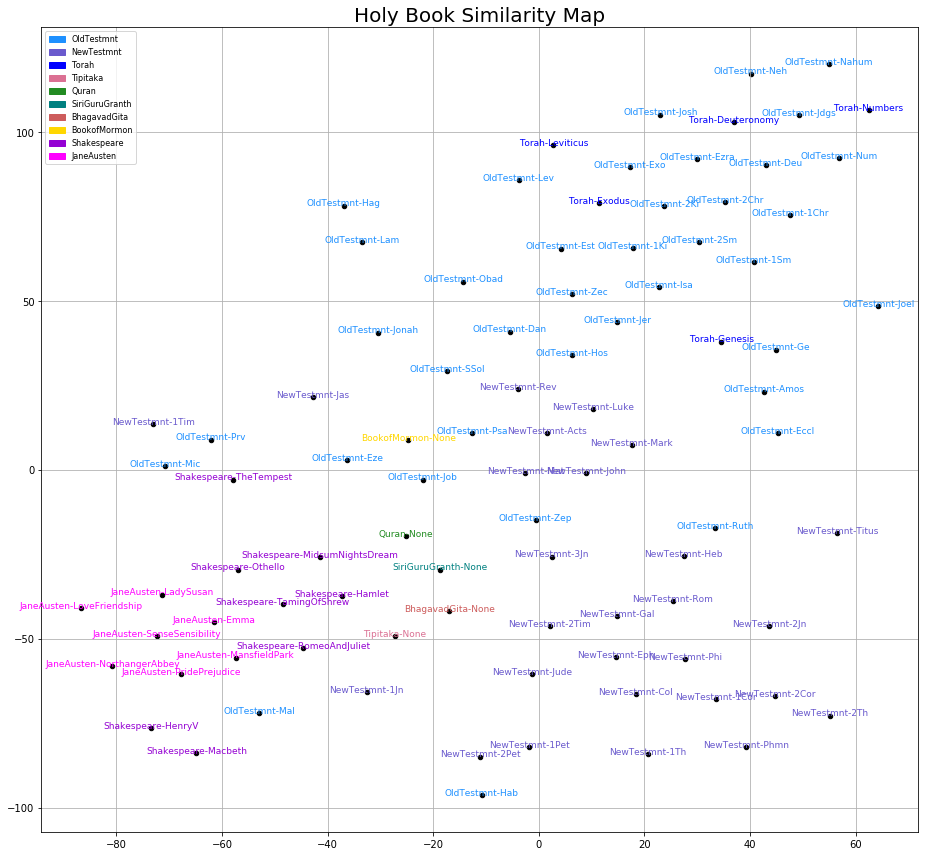


Top 12 most related books


,book1,book2,distance
572,NewTestmnt-2Pet,NewTestmnt-1Pet,9.7490
3194,NewTestmnt-Heb,OldTestmnt-Ruth,10.2963
186,OldTestmnt-Ge,Torah-Genesis,10.5483
322,NewTestmnt-1Cor,NewTestmnt-2Cor,11.1878
155,JaneAusten-Emma,JaneAusten-MansfieldPark,11.2134
3406,NewTestmnt-3Jn,OldTestmnt-Zep,11.2162
1152,OldTestmnt-Lam,OldTestmnt-Hag,11.2363
3186,NewTestmnt-Luke,NewTestmnt-Acts,11.2522
2069,Shakespeare-HenryV,Shakespeare-Macbeth,11.3434
3827,JaneAusten-MansfieldPark,JaneAusten-PridePrejudice,11.3757



Top 12 least related books


,book1,book2,distance
2065,Shakespeare-HenryV,OldTestmnt-Jdgs,219.0368
3274,OldTestmnt-Neh,OldTestmnt-Hab,219.4833
1349,OldTestmnt-Nahum,OldTestmnt-Mal,220.3487
4007,OldTestmnt-Jdgs,Shakespeare-Macbeth,220.6499
1346,OldTestmnt-Nahum,JaneAusten-NorthangerAbbey,223.9295
2037,Shakespeare-HenryV,OldTestmnt-Neh,224.4646
1393,OldTestmnt-Nahum,OldTestmnt-Hab,226.1138
3265,OldTestmnt-Neh,Shakespeare-Macbeth,226.7845
2052,Shakespeare-HenryV,Torah-Numbers,227.8430
3760,Torah-Numbers,Shakespeare-Macbeth,228.9460


In [23]:
tsne = TSNE(n_components=2, perplexity=27, early_exaggeration=12, init='pca',verbose=0, random_state=seed)
tsne_topics = tsne.fit_transform(X_topics)
plotmap(tsne_topics)

distances_df = calc_distances(tsne_topics)
topmost = 12
print('\nTop {} most related books'.format(topmost))
distances_df[:topmost]
print('\nTop {} least related books'.format(topmost))
distances_df[-topmost:]

## Apply MDS to LDA topics to map to 2-D and plot similarity map
Multidimensial Scaling (MDS) is a conceptually simpler approach than t-SNE to project the multidimensional topics onto two dimensional space. This results in more visual clutter (as the points are not 'forced' apart as in the t-SNE method) and a lower clustering clustering accuracy. i.e. the most and least related books are not as intuitive.

Therefore the t-SNE approach is preferred however this section is included for completeness and reference.

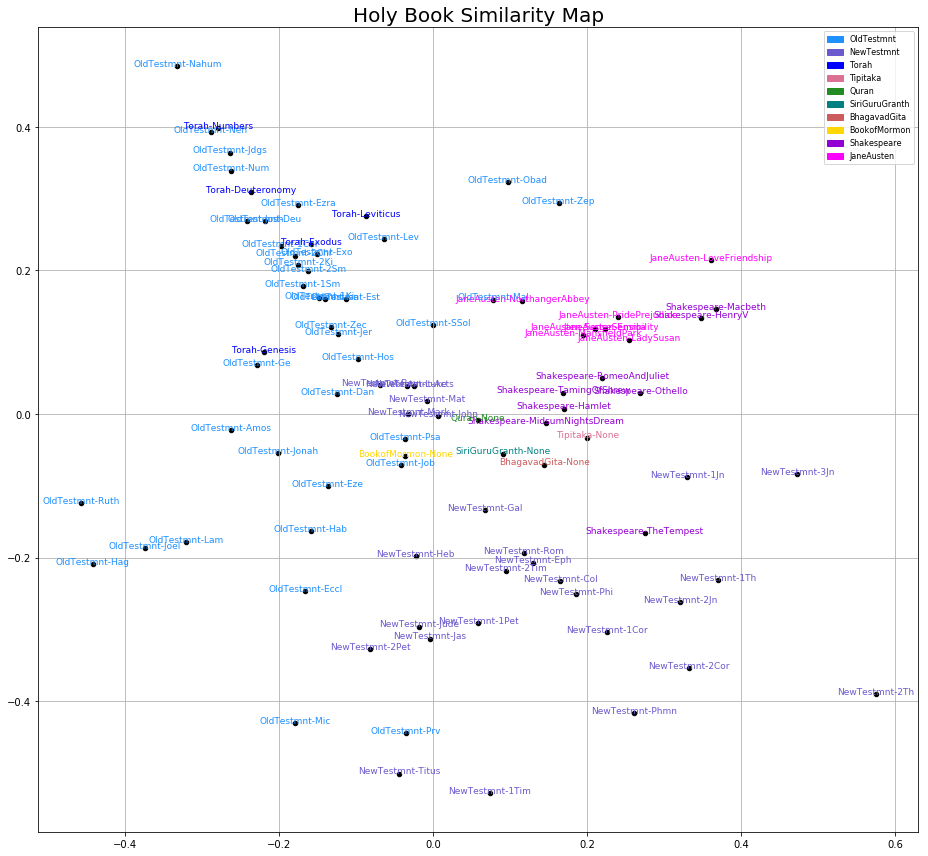


Top 12 most related books


,book1,book2,distance
1999,OldTestmnt-1Ki,OldTestmnt-Isa,0.0077
3186,NewTestmnt-Luke,NewTestmnt-Acts,0.0095
3248,OldTestmnt-Neh,Torah-Numbers,0.0109
171,JaneAusten-Emma,JaneAusten-SenseSensibility,0.0132
371,OldTestmnt-2Ki,OldTestmnt-2Chr,0.0136
2553,OldTestmnt-Jer,OldTestmnt-Zec,0.0137
1178,BookofMormon-None,OldTestmnt-Job,0.0139
357,OldTestmnt-2Ki,OldTestmnt-2Sm,0.0156
3632,Torah-Exodus,OldTestmnt-Exo,0.0159
3056,NewTestmnt-Rom,NewTestmnt-Eph,0.0176



Top 12 least related books


,book1,book2,distance
3517,NewTestmnt-2Th,OldTestmnt-Hag,1.0333
3504,NewTestmnt-2Th,OldTestmnt-Josh,1.0496
3319,OldTestmnt-Ruth,NewTestmnt-2Th,1.0666
1362,OldTestmnt-Nahum,NewTestmnt-2Cor,1.0696
3500,NewTestmnt-2Th,Torah-Deuteronomy,1.0711
1331,OldTestmnt-Nahum,NewTestmnt-Phmn,1.0778
1341,OldTestmnt-Nahum,NewTestmnt-1Tim,1.0899
490,OldTestmnt-Num,NewTestmnt-2Th,1.1105
3520,NewTestmnt-2Th,OldTestmnt-Jdgs,1.1274
3507,NewTestmnt-2Th,Torah-Numbers,1.1627


In [22]:
mds = MDS(n_components=2, metric=True, verbose=0, random_state=seed)
mds_topics = mds.fit_transform(X_topics)
plotmap(mds_topics)

distances_df = calc_distances(mds_topics)

topmost = 12
print('\nTop {} most related books'.format(topmost))
distances_df[:topmost]
print('\nTop {} least related books'.format(topmost))
distances_df[-topmost:]